In [1]:
!pip install mysql
!pip install mysql.connector

     |████████████████████████████████| 92kB 3.7MB/s 
  Created wheel for mysql: filename=mysql-0.0.2-cp37-none-any.whl size=1248 sha256=2523b01cac80ea9ce2231e66fab8f3f276081b8178b5f6a8ab5dc25e8fc364c0
  Stored in directory: /root/.cache/pip/wheels/4f/10/3f/4930effd0320769375b5094e279cb0e4a4c10a7e5811b58f8a
  Created wheel for mysqlclient: filename=mysqlclient-2.0.3-cp37-cp37m-linux_x86_64.whl size=100104 sha256=afe80b08aae1b4a1815ef99f520250f9d00bcc2d44e3eaec5e9d9492cb6ca17c
  Stored in directory: /root/.cache/pip/wheels/75/ca/e8/ad4e7ce3df18bcd91c7d84dd28c7c08db491a2a2360efed363
Successfully built mysql mysqlclient
     |████████████████████████████████| 11.9MB 260kB/s 
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp37-cp37m-linux_x86_64.whl size=247949 sha256=b96c6c861345b445ebbce4e1f79adf3499f12bcf5d93501f449f4eab078b105b
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql.connect

In [27]:
#import lib
from requests_oauthlib import OAuth1
import json
import sys
import os
import requests
import mysql.connector
import time
from lxml import etree
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import datetime
#import Secrets (mysql host, password..)
import Secrets

In [28]:
#project setting
mydb = mysql.connector.connect(
  host=Secrets.MYSQL_HOST,user=Secrets.MYSQL_USER,passwd=Secrets.MYSQL_PASSWD,database="Bilibili"
)
mycursor = mydb.cursor()

# Data Sources

## Documents for api of Bilibili:

https://github.com/SocialSisterYi/bilibili-API-collect

*   Dynamic get recommend video info

    url : "https://api.bilibili.com/x/web-interface/dynamic/region"

    params = {"jsonp": "jsonp", "rid": rid,"pn":1,"ps":30}

    jsonp: format of returned data

    rid: type of video

    pn: from page

    ps: page size
*   User Information

    url : https://api.bilibili.com/x/ugcpay-rank/elec/month/up?

    params : up_mid

    up_mid: mid of video upper


> Search Page of Bilibili

*    url:https://search.bilibili.com/all?keyword={keyword}&from_source=banner_search&spm_id_from=333.334.banner_link.1&page={}'.format(str(page))
*   This  will return a web page and we need to get data by scraping









## Access Techniques

Api: the api will return json data

Scraping : use xpath to resolve html of page and get data from the web page



## Caching

Screenshot for cache:

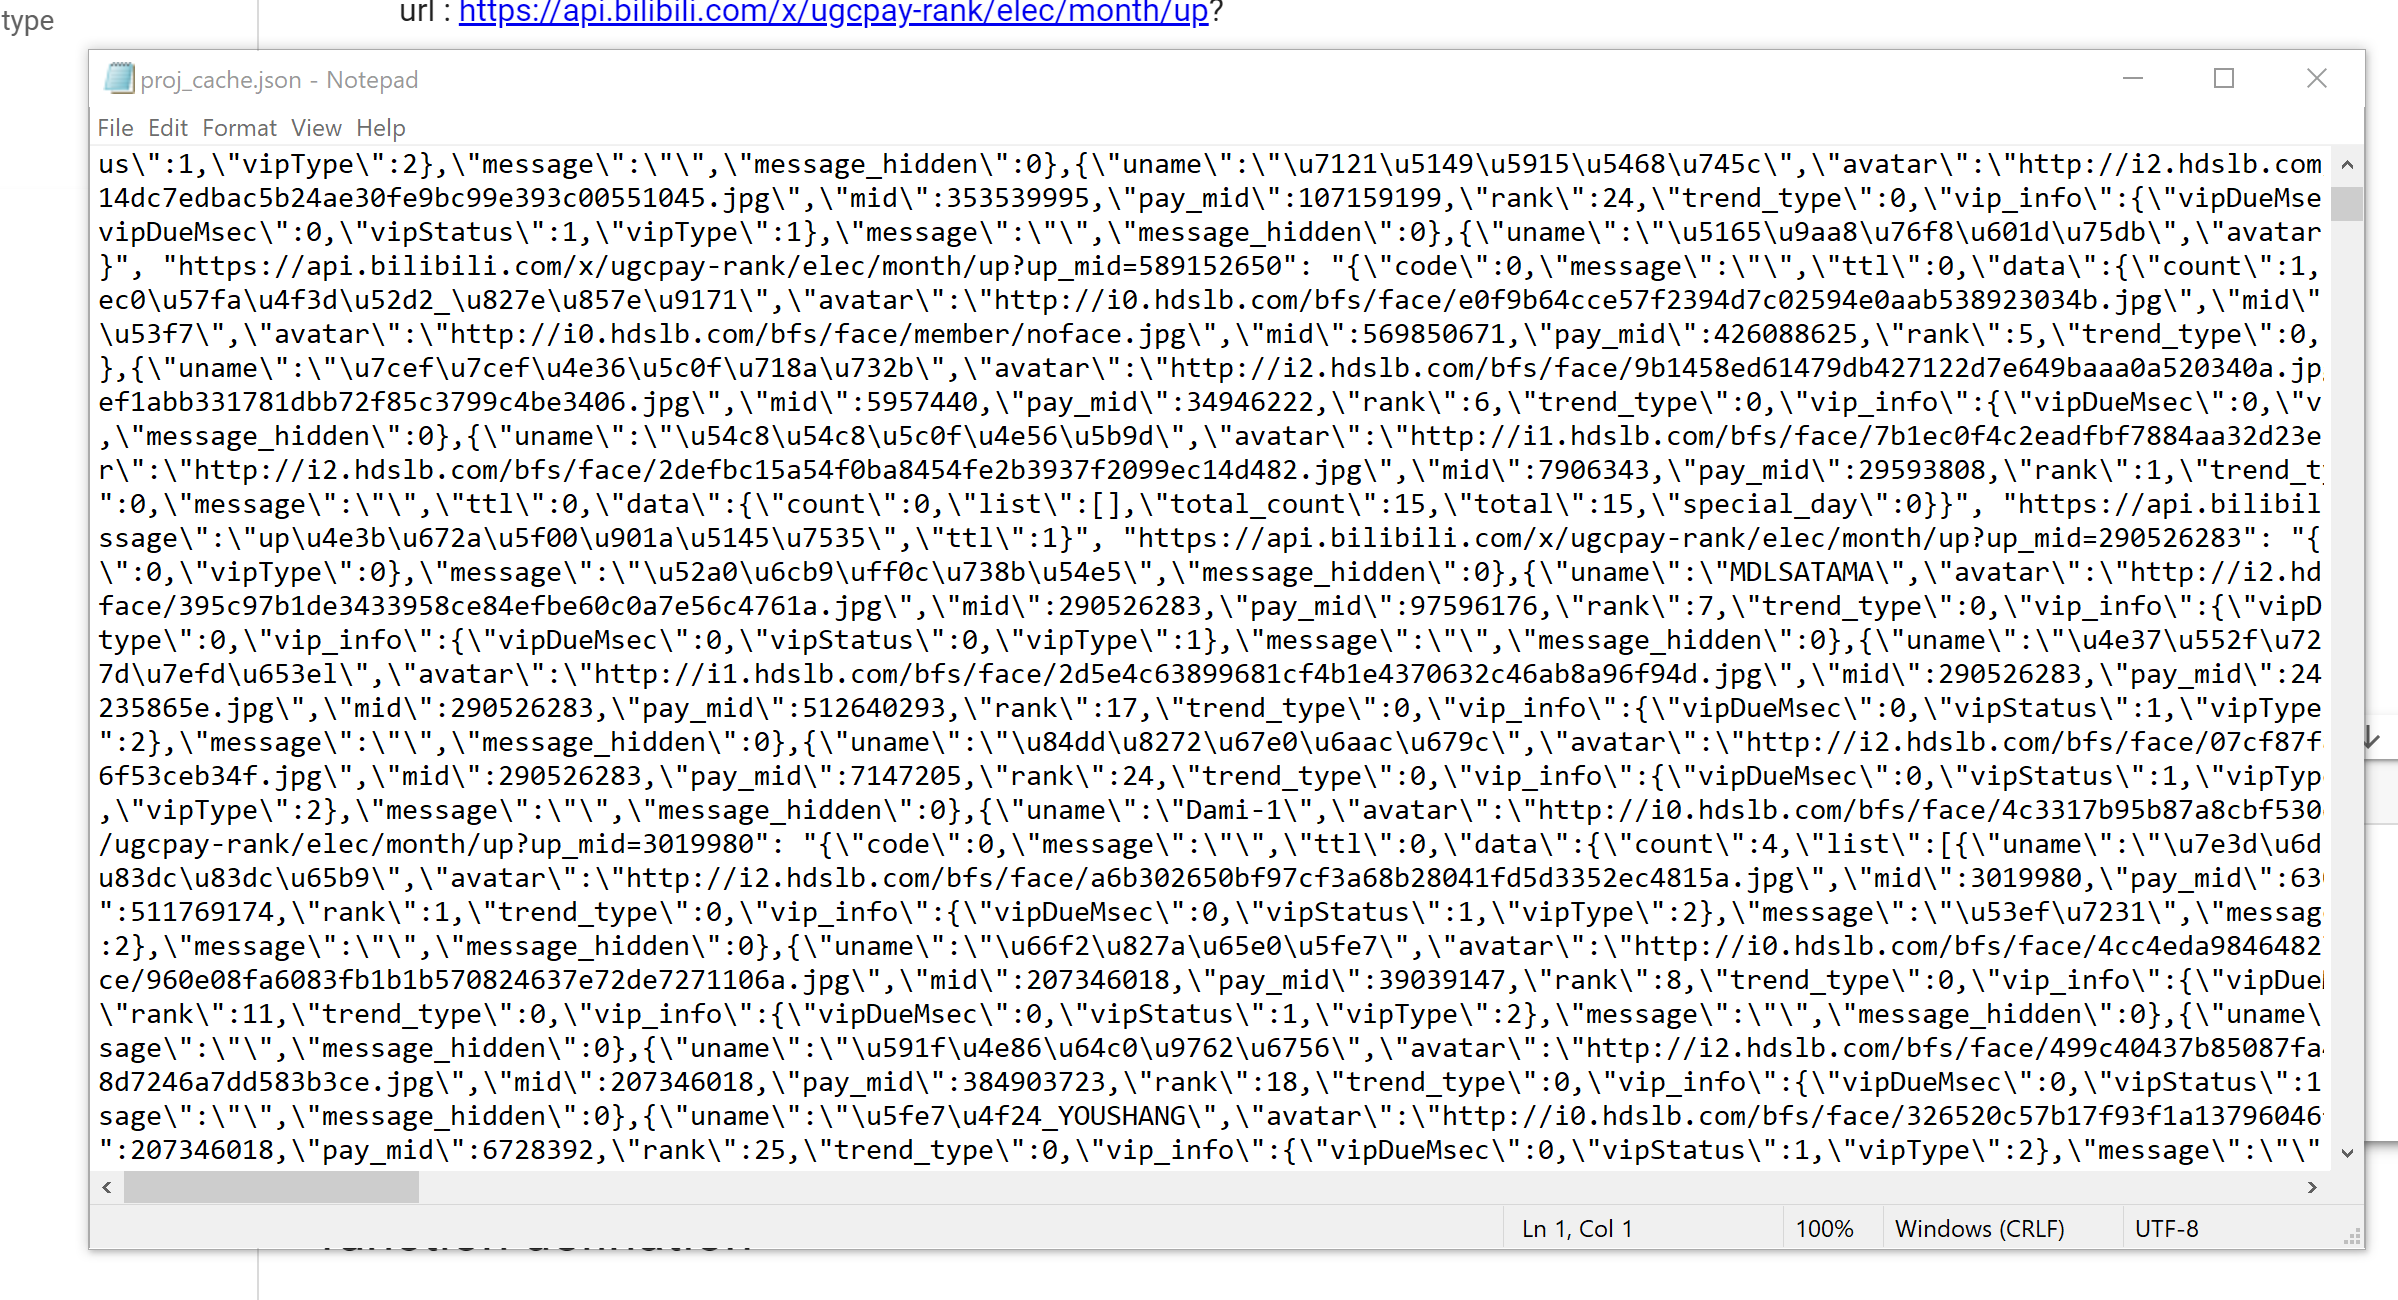

We use aiv (number of video) and mid (number of user) as key of our cache.

Cache function defination are showed in the function defination part



## Data Summary

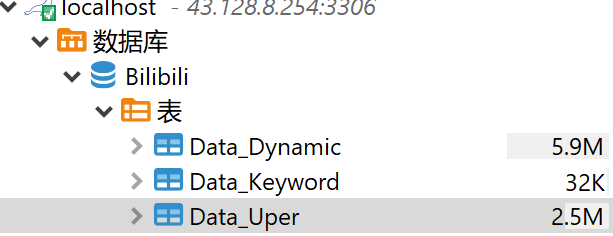

Since this is a video collection website, the “tname” is the class name of the video(I will translate the Chinese name into English); the “view” is the pageviews of the video, that means the popularity of the video; the “coin” cost the user’s coins, coin could be got through charge service, otherwise the coins are limit to user and it is hard to get, so the “coin” reflects the big fans in the video; the “favorite” means users add this video to their favorites list so that they could find then again easily, this reflects the quality of the video, which includes the useful information the video contains, the novelty and creativity of the video and other important elements of the video.



## Level of challenge for data access

Three Table:

>Data_Dynamic: record video info

Size: 5.5M

length: 9995


>Data_Keyword: record video info with keyword

size: 2.5M

length: 609

>Data_Uper: record video upper info

size : 16k

length: 152

For data_dynamic and Data_Uper we access data use api and process json data

For Data_Keyword we scrape the page and get data with xpath

# Database

## Schema
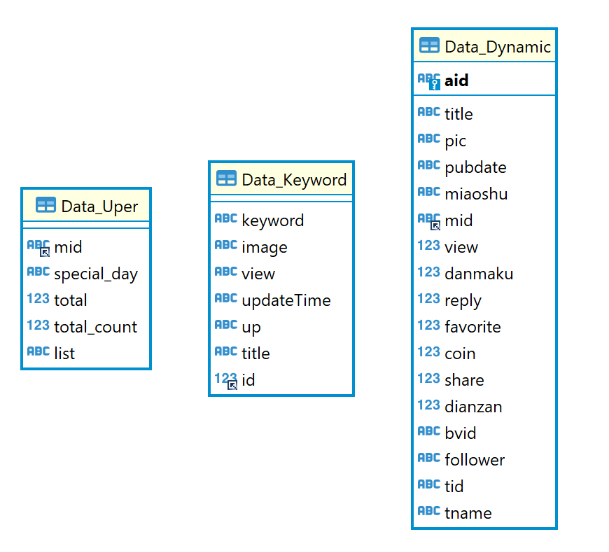


tname :the class name of the video

view: the pageviews of the video, that means the popularity of the video; 

coin: cost the user’s coins, coin could be got through charge service, otherwise the coins are limit to user and it is hard to get, so the “coin” reflects the big fans in the video;

“favorite”: means users add this video to their favorites list so that they could find then again easily, this reflects the quality of the video, which includes the useful information the video contains, the novelty and creativity of the video and other important elements of the video.

mid: id for video upper

total: the total count of paid fans

list : the list of paid fans

dannmuku: a type of comment abount the video 


    CREATE TABLE `Data_Dynamic` (
    `aid` varchar(32) NOT NULL,
    `title` varchar(255) DEFAULT NULL,
    `pic` varchar(255) DEFAULT NULL,
    `pubdate` varchar(255) DEFAULT NULL,
    `miaoshu` varchar(1024) DEFAULT NULL,
    `mid` varchar(255) DEFAULT NULL,
    `view` int(255) DEFAULT NULL,
    `danmaku` int(255) DEFAULT NULL,
    `reply` int(255) DEFAULT NULL,
    `favorite` int(255) DEFAULT NULL,
    `coin` int(255) DEFAULT NULL,
    `share` int(255) DEFAULT NULL,
    `dianzan` int(255) DEFAULT NULL,
    `bvid` varchar(255) DEFAULT NULL,
    `follower` varchar(255) DEFAULT NULL,
    `tid` varchar(255) DEFAULT NULL,
    `tname` varchar(255) DEFAULT NULL,
    PRIMARY KEY (`aid`),
    KEY `Data_Dynamic_mid_IDX` (`mid`) USING BTREE
    ) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4

## Foreign Keys

For searial reason I don't use foreign keys:

*you are making the DB work extra on every CRUD operation because it has to check FK consistency. This can be a big cost if you have a lot of churn
by enforcing relationships, FKs specify an order in which you have to add/delete things, which can lead to refusal by the DB to do what you want. (Granted, in such cases, what you are trying to do is create an Orphaned Row, and that's not usually a good thing). This is especially painful when you are doing large batch updates, and you load up one table before another, with the second table creating consistent state (but should you be doing that sort of thing if there is a possibility that the second load fails and your database is now inconsistent?).
sometimes you know beforehand your data is going to be dirty, you accept that, and you want the DB to accept.*

https://stackoverflow.com/questions/83147/whats-wrong-with-foreign-keys


## Screenshot
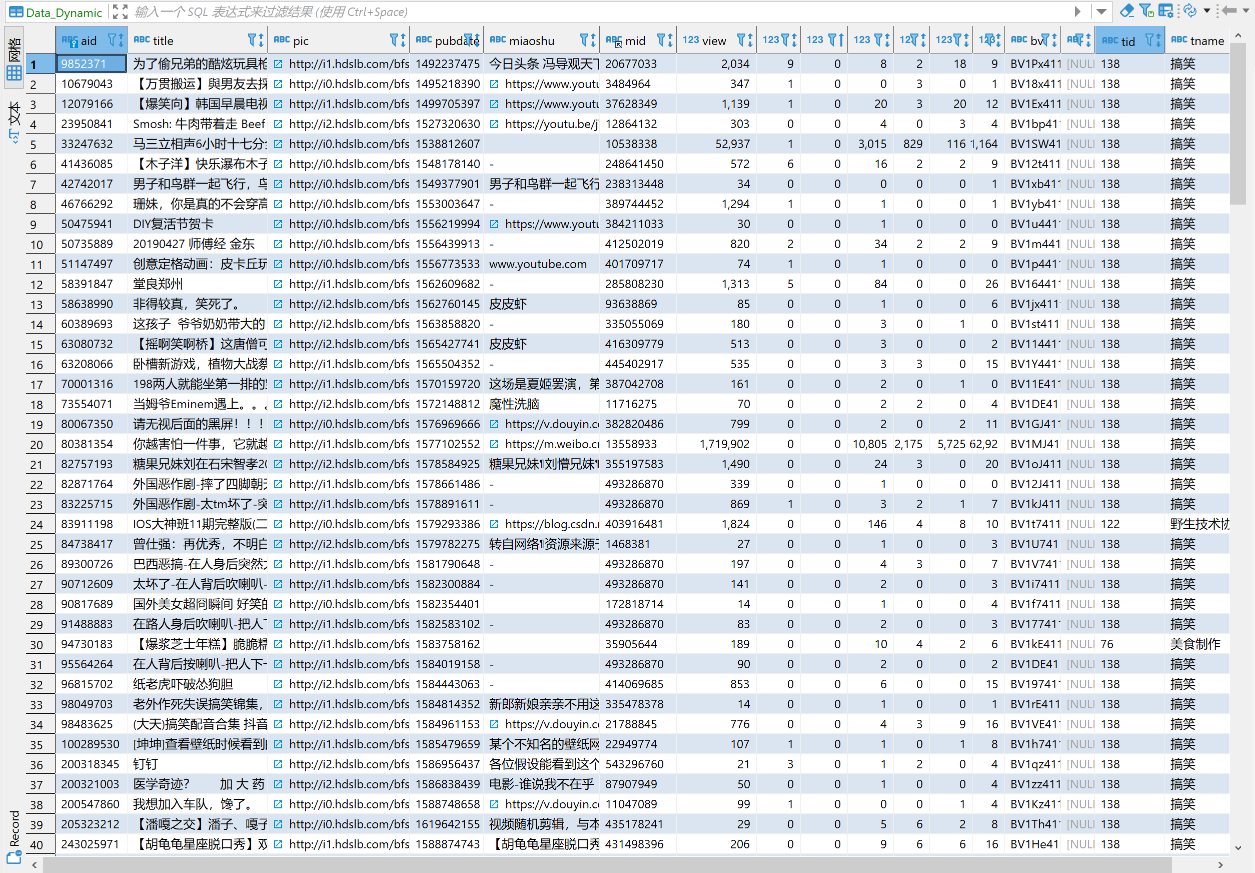

# function defination

## Cache Setting

In [6]:
CACHE_FNAME = 'proj_cache.json'
try:
    cache_file = open(CACHE_FNAME, 'r')
    cache_contents = cache_file.read()
    CACHE_DICTION = json.loads(cache_contents)
    cache_file.close()

# if there was no file, no worries. There will be soon!
except:
    CACHE_DICTION = {}
    CACHE_DICTION['aid'] = {}
    CACHE_DICTION['mid'] = {}
    CACHE_DICTION['keyword'] = {}

## Request Function

In [7]:
def make_request_using_cache(url,key_type,key,headers=None,params=None):
    unique_ident = url
    ## first, look in the cache to see if we already have this data
    if unique_ident in CACHE_DICTION[key_type]:
        print("Getting cached data...")
        return CACHE_DICTION[key_type][unique_ident]
    else:
        print("Making a request for new data...")
        # Make the request and cache the new data
        resp = requests.get(url,headers=headers,params=params)
        CACHE_DICTION[key_type][unique_ident] = resp.text
        dumped_json_cache = json.dumps(CACHE_DICTION)
        fw = open(CACHE_FNAME, "w")
        fw.write(dumped_json_cache)
        fw.close()  # Close the open file
        return CACHE_DICTION[key_type][unique_ident]

In [8]:
def get_page(page,keyword):
    try:
        headers = {
            'Cookie':'LIVE_BUVID=AUTO5015218915110407;sid=4oag5i0u;fts=1521891539;pgv_pvi=3655305216; UM_distinctid=16257cdfffd2e4-032750a28294b2-3b60450b-100200-16257cdfffe2a0;buvid3=7B94813D-1039-4A88-A1EE-9AEFDF54BE05140244infoc;rpdid=kxsliqpkisdosikxllmww;CURRENT_QUALITY=80;finger=edc6ecda',
            'Host':'search.bilibili.com',
            'Referer':'https://www.bilibili.com/',
            'Upgrade-Insecure-Requests':'1',
            'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
        }
        url='https://search.bilibili.com/all?keyword='+keyword+'&from_source=banner_search&spm_id_from=333.334.banner_link.1&page={}'.format(str(page))
        response=requests.get(url,headers=headers)
        return response
    except Exception:
        return None

In [9]:
def xpath_parse_page(html):
    data = etree.HTML(html)
    items = data.xpath('//*[@class="video-list clearfix"]/li')
    for item in items:
        yield{
            'video_image':item.xpath('./a/div/div[1]/img/@src')[0],
            'video_title':item.xpath('./div/div[1]/a/text()')[0],
            'video_view':item.xpath('./div/div[3]/span[1]/text()')[0].strip(),
            'video_updateTime':item.xpath('./div/div[3]/span[3]/text()')[0].strip(),
            'video_up':item.xpath('./div/div[3]/span[4]/a/text()')[0]
        }

In [10]:
def fetch_keyword(keyword,mycursor):
  for i in xpath_parse_page(get_page(1,keyword).text):
        data_image = str(i['video_image'])
        data_title = str(i['video_title'])
        data_view = str(i['video_view'])
        data_updateTime = str(i['video_updateTime'])
        data_up = str(i['video_up'])
        sql = "INSERT INTO Data_Keyword (keyword,image,title,view,updateTime,up)\
VALUES (%s,%s,%s,%s,%s,%s)"
        val = (keyword,data_image, data_title,data_view,data_updateTime,data_up)
        mycursor.execute(sql, val)
        mydb.commit()

In [11]:
# we can't use cache here because of dynamic returned data
def fetch_dynamic(rid):
    baseurl = "https://api.bilibili.com/x/web-interface/dynamic/region"
    params = {"jsonp": "jsonp", "rid": rid,"pn":1,"ps":30}
    response = requests.get(baseurl, params=params)
    return response.text

In [12]:
def fetch_video_info(aid):
    headers = {
            'Cookie':'buvid3=65714345-2A1A-4299-A026-4E1C3B26E7BB53930infoc; LIVE_BUVID=AUTO2215807508884432; rpdid=|(J~JY~RYu)|0J\'ul)|~lu|R); CURRENT_FNVAL=80; blackside_state=1; PVID=14; _uuid=3E289262-8113-2D6A-52BE-3EAAFE2A16C931394infoc; bfe_id=5db70a86bd1cbe8a88817507134f7bb5',
            'Host':'api.bilibili.com',
            'Referer':'https://www.bilibili.com/',
            'Upgrade-Insecure-Requests':'1',
            'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
        }
    baseurl = "https://api.bilibili.com/x/web-interface/archive/stat?aid="+aid
    params = {"jsonp": "jsonp", "rid": 138,"pn":1,"ps":30}
    response = make_request_using_cache(baseurl,'aid',aid,params=params,headers=headers)
    return response

In [13]:
def fetch_user(mid):
    headers = {
            'Cookie':'buvid3=65714345-2A1A-4299-A026-4E1C3B26E7BB53930infoc; LIVE_BUVID=AUTO2215807508884432; rpdid=|(J~JY~RYu)|0J\'ul)|~lu|R); CURRENT_FNVAL=80; blackside_state=1; PVID=14; _uuid=3E289262-8113-2D6A-52BE-3EAAFE2A16C931394infoc; bfe_id=5db70a86bd1cbe8a88817507134f7bb5',
            'Host':'api.bilibili.com',
            'Referer':'https://www.bilibili.com/',
            'Upgrade-Insecure-Requests':'1',
            'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
        }
    baseurl = "https://api.bilibili.com/x/ugcpay-rank/elec/month/up?up_mid="+mid
    response = make_request_using_cache(baseurl,'mid',mid,headers=headers)
    return response

## Example Data

In [108]:
json.loads(fetch_user('543319400'))['data']['list']
tempResult = fetch_user('543319400')
json.loads(tempResult)['data']['count']

Getting cached data...
Getting cached data...


0

In [84]:
json.loads(fetch_video_info('799887089'))['data']

Getting cached data...


{'aid': 799887089,
 'argue_msg': '',
 'bvid': 'BV1Vy4y1b74w',
 'coin': 1659,
 'copyright': 1,
 'danmaku': 610,
 'evaluation': '',
 'favorite': 1074,
 'his_rank': 0,
 'like': 7363,
 'no_reprint': 1,
 'now_rank': 0,
 'reply': 1781,
 'share': 895,
 'view': 150103}

In [148]:
tempResult = fetch_dynamic('160')
json.loads(tempResult)['data']['archives']

[{'aid': 289973187,
  'bvid': 'BV16f4y1W7rP',
  'cid': 320663441,
  'copyright': 2,
  'ctime': 1617709847,
  'desc': 'https://www.youtube.com/watch?v=ZjaIJjyK-Dk\n大阪 凌晨 2名日本男子恶意破坏价值150万日元的螃蟹装饰品！没有人我们想做什么都行\nカニ看板破壊し男2人逃走\u3000防犯カメラに一部始終(2021年4月6日)',
  'dimension': {'height': 1080, 'rotate': 0, 'width': 1920},
  'duration': 61,
  'dynamic': '',
  'owner': {'face': 'http://i0.hdslb.com/bfs/face/8f5a4b91666a4d1ed43cff1f52f2c1a5161d2a3c.jpg',
   'mid': 512516310,
   'name': '基米HCl'},
  'pic': 'http://i1.hdslb.com/bfs/archive/a07f91e62f4ab29ef01446fc978d3039286a5690.jpg',
  'pubdate': 1617709847,
  'rights': {'autoplay': 1,
   'bp': 0,
   'download': 0,
   'elec': 0,
   'hd5': 0,
   'is_cooperation': 0,
   'movie': 0,
   'no_background': 0,
   'no_reprint': 0,
   'pay': 0,
   'ugc_pay': 0,
   'ugc_pay_preview': 0},
  'season_type': 0,
  'short_link': 'https://b23.tv/BV16f4y1W7rP',
  'short_link_v2': 'https://b23.tv/BV16f4y1W7rP',
  'stat': {'aid': 289973187,
   'coin': 4,
   'danmaku': 2,
  

# Fetch data from differnt type

In [14]:
def fetch_mid_info(mid,mycursor):
    tempResult = fetch_user(str(mid))
    if mid in CACHE_DICTION['mid']:
      return
    if json.loads(tempResult)['code'] == 0:
        data_special_day = json.loads(tempResult)['data']['special_day']
        data_total = json.loads(tempResult)['data']['total']
        data_total_count = json.loads(tempResult)['data']['total_count']
        data_list = str(json.loads(tempResult)['data']['list'])
        sql = "SELECT * FROM Data_Uper WHERE mid = %s"
        val = (mid,)
        mycursor.execute(sql,val)
        myresult = mycursor.fetchall()
        if len(myresult)==0:
            sql = "INSERT INTO Data_Uper (mid,list,special_day,total,total_count)\
VALUES (%s,%s,%s,%s,%s)"
            val = (mid,data_list, data_special_day,data_total,data_total_count)
            mycursor.execute(sql, val)
            mydb.commit()
            #print(mycursor.rowcount, "record inserted.")

In [123]:
fetch_mid_info('543319400',mycursor)

Getting cached data...


In [16]:
def fetch_info_once(mycursor,rid):
    tempResult = fetch_dynamic(str(rid))
    #print(json.dumps(tempResult))
    if json.loads(tempResult)['code'] != 0:
      return
    for i in json.loads(tempResult)['data']['archives']:
        data_aid = str(i['aid'])
        data_tid = str(i['tid'])
        data_tname = str(i['tname'])
        data_pic = str(i['pic'])
        data_title = str(i['title'])
        data_pubdate = str(i['pubdate'])
        data_desc = str(i['desc'])
        data_mid = str(i['owner']['mid'])
        data_view = str(i['stat']['view'])
        data_danmaku = str(i['stat']['danmaku'])
        data_reply = str(i['stat']['reply'])
        data_favorite = str(i['stat']['favorite'])
        data_coin = str(i['stat']['coin'])
        data_share = str(i['stat']['share'])
        data_like = str(i['stat']['like'])
        data_bvid = str(i['bvid'])
        sql = "SELECT * FROM Data_Dynamic WHERE aid = %s"
        val = (data_aid,)
        mycursor.execute(sql,val)
        myresult = mycursor.fetchall()
        if len(myresult)==0:
            sql = "INSERT INTO Data_Dynamic (aid,title,pic,pubdate,miaoshu,mid,view,danmaku,\
reply,favorite,coin,share,dianzan,bvid,tid,tname)\
VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"
            val = (data_aid, data_title,data_pic,data_pubdate,data_desc,data_mid,data_view,data_danmaku,\
           data_reply,data_favorite,data_coin,data_share,data_like,data_bvid,data_tid,data_tname)
            mycursor.execute(sql, val)
            mydb.commit()
            fetch_mid_info(data_mid,mycursor)
            time.sleep(1)
            #print(mycursor.rowcount, "record inserted.")

In [133]:
fetch_info_once(mycursor,137)

Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...


In [20]:
count = 50
while count>=0:
    count = count-1
    # Food
    fetch_info_once(mycursor,211)
    time.sleep(3)
    # Music 
    fetch_info_once(mycursor,3)
    time.sleep(3)
    # Life Channel
    fetch_info_once(mycursor,160)
    time.sleep(3)
    # Knowledge
    fetch_info_once(mycursor,36)
    time.sleep(3)

Making a request for new data...
Making a request for new data...
Getting cached data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Getting cached data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Getting cached data...
Making a request for new data...
Getting cached data...
Getting cached data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Getting cached data...
Making a request for new data...
Making a request for new data...
Getting cached data...
Getting cached data...
Making a request for new data...
Getting cached data...
Getting cached data...
Getting cached data...
Getting cached data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Making a request for new data...
Getting cached data...
Making a request for new data...
Making a

DataError: ignored

In [ ]:
# Fetch different keyword
fetch_keyword('python',mycursor)
fetch_keyword('java',mycursor)
fetch_keyword('c++',mycursor)
fetch_keyword('js',mycursor)
fetch_keyword('rust',mycursor)
fetch_keyword('go',mycursor)

# Data Processing & Demo

In [ ]:
!pip install ipywidgets
import ipywidgets as widgets
import pandas as pd
from ipywidgets import interact, interact_manual
from datetime import datetime
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.5)

In [5]:
query_tid = 138
sql = "SELECT * FROM Data_Dynamic WHERE tid = %s"
val = (query_tid,)
mycursor.execute(sql,val)
myresult = mycursor.fetchall()

In [6]:
df = pd.DataFrame(list(myresult))
columnDes = mycursor.description
columnNames = [columnDes[i][0] for i in range(len(columnDes))]
df.columns = columnNames

In [7]:
sql = "SELECT * FROM Data_Keyword"
mycursor.execute(sql)
myresult = mycursor.fetchall()
df_keyword = pd.DataFrame(list(myresult))
columnDes = mycursor.description
columnNames = [columnDes[i][0] for i in range(len(columnDes))]
df_keyword.columns = columnNames

## Data Presentation and interaction



> Technologies

documents:
https://ipywidgets.readthedocs.io/en/latest/

ipywidgets, also known as jupyter-widgets or simply widgets, are interactive HTML widgets for Jupyter notebooks and the IPython kernel.

Notebooks come alive when interactive widgets are used. Users gain control of their data and can visualize changes in the data.




> Instructions for use

After fetching data from your database, we can use ipywidgets to show data and we can use some control for example slider to change the data presentation



> Application capabilities

The main function is the video filtering function, which can filter out videos according to different dimensions. At the same time, we also put forward the concept of retaining fans, which can better recommend high-quality videos.
At the same time, according to different keywords, we have also done data visualization, and we can observe the changes in popularity.

> Demo Video

https://drive.google.com/file/d/1z9bFW6iUHXq4Y7joQAxqLgVgtG6BTAFu/view?usp=sharing



> Demo



In [26]:
@interact
def show_articles_more_than(column=['view'],x=(10, 20000000, 100)):
    return df.loc[df[column] > x]

interactive(children=(Dropdown(description='column', options=('view',), value='view'), IntSlider(value=9999910…

In [9]:
@interact
def show_articles_more_than(column=['reply', 'coin', 'favorite'],x=(10, 100000, 100)):
    return df.loc[df[column] > x]

interactive(children=(Dropdown(description='column', options=('reply', 'coin', 'favorite'), value='reply'), In…

> **Loyal fans ratio**

> the loyal fans ratio counts for the amount of loyal fans in all the video audience. The method to measure the loyal fans ratio is “coin”/“view”. I want to find the relationship between the loyal fans ratio and “tname”. The loyal fans ratio are the user group that tend to spend money in the video and the video contents, so the loyal fans ratio is important for the video maker to take into consideration.

**Use this ratio， we can recommend some high quality video**


In [22]:
sql = "SELECT aid,title,coin,view,tid,tname,bvid FROM Data_Dynamic"
mycursor.execute(sql)
myresult = mycursor.fetchall()
df_loyal_fans_ratio = pd.DataFrame(list(myresult))
columnNames = ['aid','title','coin','view','tid','tname','bvid']
df_loyal_fans_ratio.columns = columnNames
def calculate_ratio(row):
        out = {}
        try:
          out['Loyal_fans_ratio'] = np.float(row['coin'])/np.float(row['view']) * 1000
          out['Link'] = 'https://www.bilibili.com/video/' + row['bvid']
        except:
          out['Loyal_fans_ratio'] = 0
          out['Link'] = 'https://www.bilibili.com/video/' + row['bvid']
        return pd.Series(out)
df_loyal_fans_ratio[['Loyal_fans_ratio','Link']] = df_loyal_fans_ratio.apply(calculate_ratio, axis=1)

In [25]:
@interact
def show_articles_more_than(column=['Loyal_fans_ratio'],x=(0, 200, 0.01)):
    return df_loyal_fans_ratio.loc[(df_loyal_fans_ratio[column] > x) & (df_loyal_fans_ratio['view']>10000)]

interactive(children=(Dropdown(description='column', options=('Loyal_fans_ratio',), value='Loyal_fans_ratio'),…

## Data with different keyword

For example, we can search different programming language in Bilibli and show the view of video to represent the fever of language

In [ ]:
def convert_num(value):
    if '万' in str(value):
      new_value = np.float(str(value).replace('万', ''))*10000
    else:
      new_value = np.float(value)
    return np.int(new_value)
    
df_keyword['view']=df_keyword['view'].apply(convert_num)
python_view = df_keyword.loc[df_keyword['keyword'] =='python']['view'].sum()/df_keyword.loc[df_keyword['keyword'] =='python']['view'].count()
df_keyword['updateTime'] = df_keyword['updateTime'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

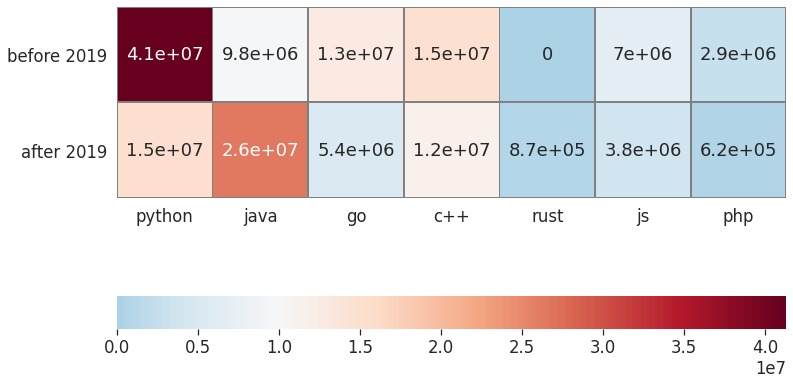

In [147]:
lan_list =['python','java','go','c++','rust','js','php']
year_list = ['before 2019','after 2019']
list_before_2019 = []
list_after_2019 = []
for i in lan_list:
  list_before_2019.append(df_keyword.loc[(df_keyword['updateTime']<datetime.strptime('2019-01-01', '%Y-%m-%d')) & (df_keyword['keyword'] ==i)]['view'].sum())
  list_after_2019.append(df_keyword.loc[(df_keyword['updateTime']>datetime.strptime('2019-01-01', '%Y-%m-%d')) & (df_keyword['keyword'] ==i)]['view'].sum())
sns.set_context({"figure.figsize":(12,12)})

lan_result_pd = pd.DataFrame(np.array([list_before_2019,list_after_2019]) )
lan_result_pd.columns = lan_list
lan_result_pd.index = year_list
sns.heatmap(data=lan_result_pd,square=True,cmap="RdBu_r",linecolor="grey",linewidths=0.9,center=10000000,annot=True,cbar_kws={"orientation":"horizontal"})

We can see the changes in the popularity of different computer languages in different periods, which can reflect the changes in the popularity of computer languages by the public.